# Aprendizaje Supervisado: Algoritmos de Clasificación

<img src="imagenes/ia_clas0.png" width=750>

<img src="imagenes/ia.jfif" width=600>

Tipos de algoritmos para resolver una clasificación:
    
    * Arboles de decisión
    * Máquinas de vectores de soporte
    * Naive Bayes
    * Regresión Logística
    * Bosques Aleatorios

# Arboles de decisión

<img src='imagenes/gashe.png'>

## Preparamos los datos: GGAL +6 predictores

In [1]:
import yfinance as yf, numpy as np, pandas as pd

medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,pctChange,fw,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,,,,,,,,,
2000-07-25,17.484375,17.7500,16.7500,17.5000,16.033369,126200,NaN,-0.185714,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-26,17.250000,17.5625,17.1875,17.5000,16.033369,28900,0.000000,-0.192857,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-27,17.500000,17.6250,17.3750,17.5000,16.033369,61200,0.000000,-0.160714,NaN,NaN,0.000000,NaN,NaN,NaN
2000-07-28,17.562500,17.5625,17.1250,17.3750,15.918845,146100,-0.007143,-0.151079,0.000000,NaN,0.071547,NaN,NaN,NaN
2000-07-31,17.500000,17.6875,16.8750,17.6875,16.205154,178400,0.017986,-0.180212,0.729166,NaN,0.186460,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-17,10.160000,10.3300,9.8900,9.9100,9.910000,573300,-0.030333,NaN,0.613881,0.194531,0.671824,-0.157884,-0.033126,-0.319885
2021-06-18,9.850000,9.8700,9.5300,9.6700,9.670000,1276800,-0.024218,NaN,0.569526,0.193724,0.670559,-0.154222,-0.024858,-0.314266
2021-06-21,9.770000,9.7700,9.4500,9.4500,9.450000,362000,-0.022751,NaN,0.531607,0.195323,0.669181,-0.150916,-0.017929,-0.308843


## Definimos lo que vamos a querer predecir

In [2]:

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]

X

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,
2002-08-01,0.5164,1.2248,2.0035,-0.9164,-0.9198,-0.9182
2002-08-02,0.5164,1.2248,1.9966,-0.9173,-0.9188,-0.9191
2002-08-05,0.5064,1.2245,1.9898,-0.9183,-0.9177,-0.9198
2002-08-06,0.4863,1.2221,1.9834,-0.9193,-0.9163,-0.9204
2002-08-07,0.4863,1.2220,1.9766,-0.9202,-0.9148,-0.9211
...,...,...,...,...,...,...
2021-01-25,0.3321,0.2785,0.8163,-0.3940,-0.1832,-0.4948
2021-01-26,0.4304,0.2800,0.8173,-0.3908,-0.1845,-0.4925
2021-01-27,0.4188,0.2790,0.8147,-0.3876,-0.1865,-0.4901


In [2]:
sum(y), len(y)   # fw positivo, totales

(2624, 4657)

## Separamos datos de entrenamiento de validación

In [3]:
len(X), len(y)

(4657, 4657)

In [4]:
from sklearn.model_selection import train_test_split

# Entrenamos con el 60% de los datos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [5]:
len(X_train)

2794

In [6]:
len(X_test)

1863

In [7]:
X_train[:10]

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,
2014-01-31,0.3090,0.2990,0.5641,0.5531,0.4259,0.5740
2015-12-23,0.5623,0.2704,0.5304,0.2880,0.3398,0.3539
2007-11-21,0.4574,0.1493,0.3802,-0.0370,-0.0685,-0.0197
2019-10-30,0.3662,0.6771,0.9746,-0.5252,-0.5352,-0.5183
2013-05-13,0.4908,0.2171,0.5343,-0.0857,-0.0295,-0.2141
2012-01-31,0.5597,0.2678,0.5682,-0.3468,-0.4112,-0.2596
2004-01-26,0.5834,0.2672,1.2247,1.1573,0.9675,1.3124
2005-10-28,0.3754,0.1381,0.4756,0.1084,0.0900,0.1307
2017-02-15,0.6872,0.1680,0.3862,0.0995,0.0986,0.1313


## Importamos el modelo

In [8]:
from sklearn.tree import DecisionTreeClassifier
modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=6) # por default es gini, otros entropy

Parámetros importantes:
    
* criterion: entropy/gini
* <b>max_depth</b>: Cantidad de subnodos desde cada hilo ppal (profundidad)
* random_state

$$ {\text{Ganancia de información, Entropia}}(S)= \large - \sum _{i=1}^{n}p_{i}\log _{2}p_{i} $$

$$ {\text{Impureza de Gini} \hspace{0.5cm}  \large I_{G}(p)=\sum _{i=1}^{m}p_{i}(1-p_{i})=\sum _{i=1}^{m}(p_{i}-{p_{i}}^{2})=1-\sum _{i=1}^{m}{p_{i}}^{2}} $$

Ver Shannon y Weaber formulacion matematica de la teoría de la información

## Entrenamiento

In [9]:
modelo.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

## Corremos el modelo

In [10]:
y_pred = modelo.predict(X_test)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [11]:
pd.DataFrame(y_pred).groupby(0).size()

0
0     728
1    1135
dtype: int64

In [12]:
modelo.predict(X_test)

array([0, 1, 1, ..., 1, 1, 1])

## Obtenemos las predicciones 

In [13]:
modelo.predict_proba(X_test)

array([[0.66438356, 0.33561644],
       [0.4034188 , 0.5965812 ],
       [0.4034188 , 0.5965812 ],
       ...,
       [0.4034188 , 0.5965812 ],
       [0.01538462, 0.98461538],
       [0.09115282, 0.90884718]])

## Matriz de Confusión

<img src='imagenes/machine_learning_mc_sklearn.png' width='600'>

### Matriz de confusión "a mano"

In [14]:
resultados = list(zip(y_test, y_pred))

manteca = 0
mike = 0
yoteavise = 0
allin = 0

for real, prediccion in resultados:
    
    if (real==0) & (prediccion==0):
        # Verdaderos negativos
        yoteavise +=1
    if (real==0) & (prediccion==1):
        # Falsos positivos
        allin +=1
    if (real==1) & (prediccion==0):
        # Falsos negativos
        mike +=1
    if (real==1) & (prediccion==1):
        # Verdaderos positivos
        manteca +=1


yoteavise, allin, mike, manteca

(545, 259, 183, 876)

In [15]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
m = np.array(confusion_matrix(y_test, y_pred, normalize=None))
m

array([[545, 259],
       [183, 876]], dtype=int64)

## Normalizado de matriz de confusión

In [16]:
m = np.array(confusion_matrix(y_test, y_pred, normalize='all'))
m

array([[0.29253892, 0.13902308],
       [0.09822866, 0.47020934]])

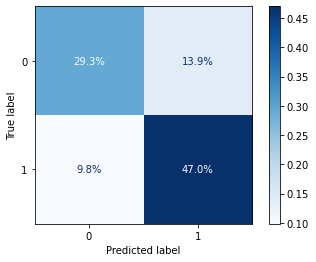

In [17]:
plot_confusion_matrix(modelo, X_test, y_test, values_format='.1%', normalize='all', cmap='Blues')

In [18]:
m = np.array(confusion_matrix(y_test, y_pred, normalize='pred'))
m

array([[0.74862637, 0.22819383],
       [0.25137363, 0.77180617]])

In [19]:
m = np.array(confusion_matrix(y_test, y_pred, normalize='true'))
m

array([[0.6778607 , 0.3221393 ],
       [0.17280453, 0.82719547]])

In [20]:
from sklearn.metrics import confusion_matrix

m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

matriz = {'manteca':m[1][1], 'mike oscilator':m[1][0],'all in':m[0][1], 'yo te avise':m[0][0]}

resumen = {'aciertos' : f"{matriz['manteca']+matriz['yo te avise']:.1%}", 
           'sesgo +': f"{matriz['manteca']+matriz['all in']:.1%}"}

print('Arboles de decisión: \n',m,'\nPorcentajes:\n',matriz,'\n',resumen)

Arboles de decisión: 
 [[0.29 0.14]
 [0.1  0.47]] 
Porcentajes:
 {'manteca': 0.47, 'mike oscilator': 0.1, 'all in': 0.14, 'yo te avise': 0.29} 
 {'aciertos': '76.0%', 'sesgo +': '61.0%'}


### Ojo con la definición de tuplas

Si definimos una tupla como x=(1), me va a asignar el entero 1 a la variable "x"

Si quisiera que me asigne la tupla con el valor 1 como único valor debo poner x=(1,)

In [21]:
a = 5
b = (5)
c = (5,)

In [22]:
type(a), type(b), type(c)

(int, int, tuple)

## Vemos predicción de algún valor

In [23]:
X

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,
2002-08-01,0.5164,1.2248,2.0035,-0.9164,-0.9198,-0.9182
2002-08-02,0.5164,1.2248,1.9966,-0.9173,-0.9188,-0.9191
2002-08-05,0.5064,1.2245,1.9898,-0.9183,-0.9177,-0.9198
2002-08-06,0.4863,1.2221,1.9834,-0.9193,-0.9163,-0.9204
2002-08-07,0.4863,1.2220,1.9766,-0.9202,-0.9148,-0.9211
...,...,...,...,...,...,...
2021-01-25,0.3321,0.2785,0.8163,-0.3940,-0.1832,-0.4948
2021-01-26,0.4304,0.2800,0.8173,-0.3908,-0.1845,-0.4925
2021-01-27,0.4188,0.2790,0.8147,-0.3876,-0.1865,-0.4901


In [24]:
X_full = data_full.iloc[:,-7:-1]
X_full

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
Date,,,,,,
2000-07-25,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-26,NaN,NaN,NaN,NaN,NaN,NaN
2000-07-27,NaN,NaN,0.000000,NaN,NaN,NaN
2000-07-28,0.000000,NaN,0.071547,NaN,NaN,NaN
2000-07-31,0.729166,NaN,0.186460,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-06-17,0.613881,0.194531,0.671824,-0.157884,-0.033126,-0.319885
2021-06-18,0.569526,0.193724,0.670559,-0.154222,-0.024858,-0.314266
2021-06-21,0.531607,0.195323,0.669181,-0.150916,-0.017929,-0.308843


In [25]:
datosHoy = X_full.iloc[-1]
datosHoy

rsi         0.561255
roll_vol    0.197016
ema_vol     0.666119
cruce_1    -0.143243
cruce_2    -0.002607
cruce_3    -0.298826
Name: 2021-06-23 00:00:00, dtype: float64

In [26]:
datosHoy.values

array([ 0.56125531,  0.19701565,  0.66611876, -0.14324299, -0.00260714,
       -0.29882616])

In [27]:
modelo.predict((datosHoy,))

array([1])

In [28]:
modelo.predict_proba((datosHoy,))

array([[0.06521739, 0.93478261]])

In [29]:
ultimos = X_full[-5:]
prediccion_ultimos = modelo.predict(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)


Prediccion Ultimos 5 valores actuales
 [1 1 1 1 1]


In [30]:
ultimos = X_full[-5:]
prediccion_ultimos = modelo.predict_proba(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)


Prediccion Ultimos 5 valores actuales
 [[0.06521739 0.93478261]
 [0.06521739 0.93478261]
 [0.06521739 0.93478261]
 [0.06521739 0.93478261]
 [0.06521739 0.93478261]]


## Graficamos el modelo

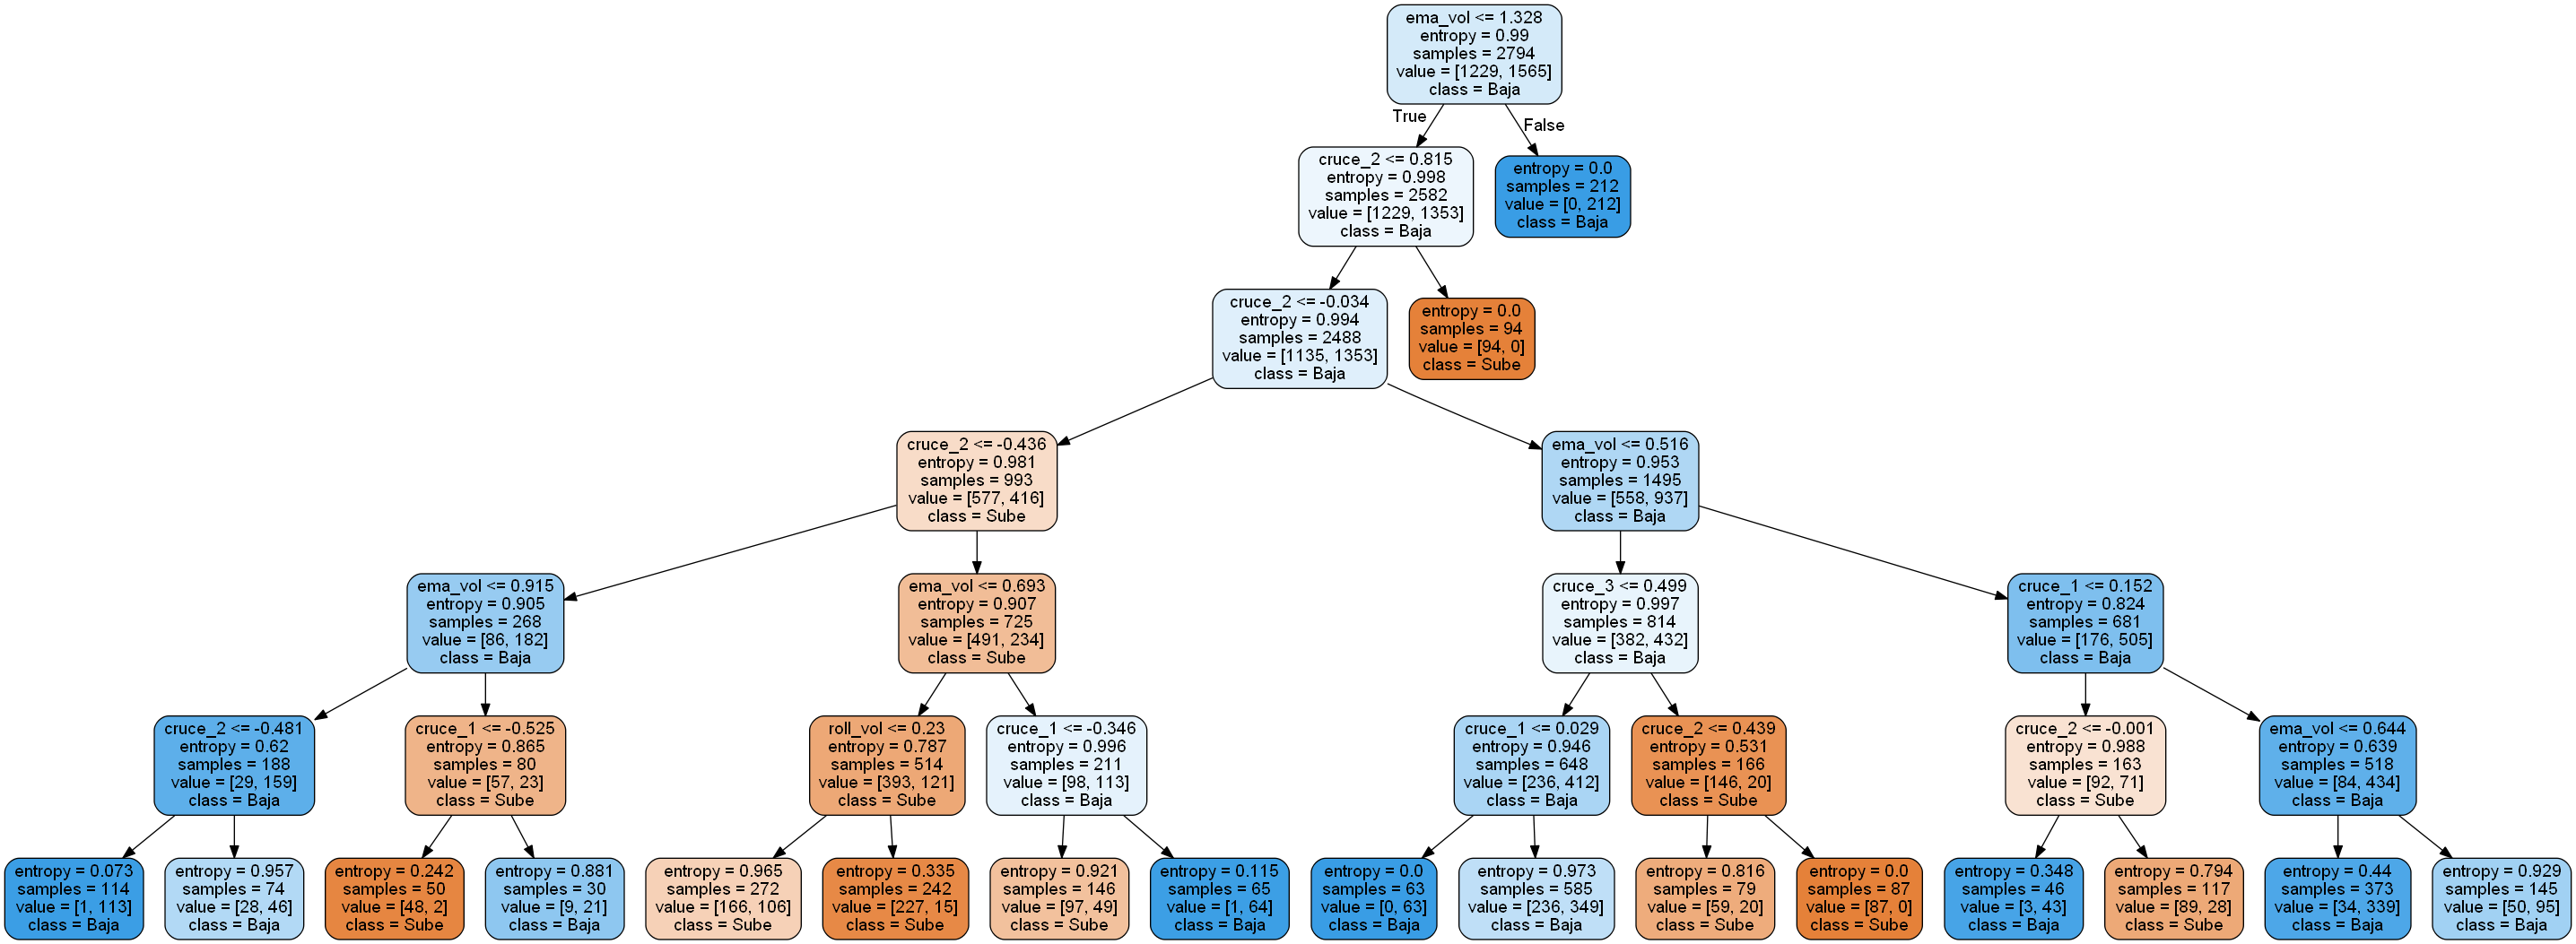

In [31]:
# pip install pydotplus

from IPython.display import Image  
from sklearn import tree
import pydotplus
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

cols = ['roll_vol','cr1','cr2','cr3']
targets = ['Sube','Baja']

dot_data = tree.export_graphviz(modelo, out_file=None, feature_names=X.columns, 
                                class_names=targets, rounded = True, filled= True)

graph = pydotplus.graph_from_dot_data(dot_data)  

# guardo la imagen en disco
graph.write_png("imagenes/gashe.png")

# imprimo en pantalla
Image(graph.create_png())

In [32]:
dot_data

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge [fontname=helvetica] ;\n0 [label="ema_vol <= 1.328\\nentropy = 0.99\\nsamples = 2794\\nvalue = [1229, 1565]\\nclass = Baja", fillcolor="#d4eaf9"] ;\n1 [label="cruce_2 <= 0.815\\nentropy = 0.998\\nsamples = 2582\\nvalue = [1229, 1353]\\nclass = Baja", fillcolor="#edf6fd"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="cruce_2 <= -0.034\\nentropy = 0.994\\nsamples = 2488\\nvalue = [1135, 1353]\\nclass = Baja", fillcolor="#dfeffb"] ;\n1 -> 2 ;\n3 [label="cruce_2 <= -0.436\\nentropy = 0.981\\nsamples = 993\\nvalue = [577, 416]\\nclass = Sube", fillcolor="#f8dcc8"] ;\n2 -> 3 ;\n4 [label="ema_vol <= 0.915\\nentropy = 0.905\\nsamples = 268\\nvalue = [86, 182]\\nclass = Baja", fillcolor="#97cbf1"] ;\n3 -> 4 ;\n5 [label="cruce_2 <= -0.481\\nentropy = 0.62\\nsamples = 188\\nvalue = [29, 159]\\nclass = Baja", fillcolor="#5dafea"] ;\n4 -> 5 ;\n6 [label="entropy = 0.073

## Overfiteamos

<AxesSubplot:>

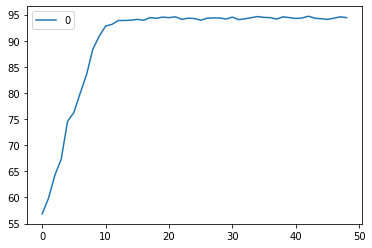

In [33]:
aciertos = []
for i in range(1,50):
    modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=i) #Definimos modelo
    modelo.fit(X_train, y_train) # Entrenamos
    y_pred = modelo.predict(X_test) # Corremos
    m = np.array(confusion_matrix(y_test, y_pred)) # medimos
    mp = (m/m.sum().sum() *100).round(2)
    aciertos.append( round(mp[0][0]+mp[1][1],2) )

aciertosTot = pd.DataFrame(aciertos)
aciertosTot.plot()

# Repaso en limpio

In [34]:
import yfinance as yf, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=7) 
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

ultimos = data_full.iloc[-5:,-7:-1]
prediccion_ultimos = modelo.predict_proba(ultimos)

m, prediccion_ultimos

[*********************100%***********************]  1 of 1 completed


(array([[0.36, 0.07],
        [0.18, 0.38]]),
 array([[0.53954802, 0.46045198],
        [0.53954802, 0.46045198],
        [0.53954802, 0.46045198],
        [0.53954802, 0.46045198],
        [0.53954802, 0.46045198]]))

# Se acuerdan de la serializacion?

In [35]:
import pickle

with open('modelo_arboles.dat' , 'wb') as file:
    pickle.dump(modelo, file)

# Reiniciamos kernel y probamos modelo pre-fiteado

In [36]:
import pickle
with open('modelo_arboles.dat' , 'rb') as file:
    m_loaded = pickle.load(file)

In [37]:
import yfinance as yf, numpy as np, pandas as pd

medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

ultimos = data.iloc[-5:,-6:]
prediccion_ultimos = m_loaded.predict_proba(ultimos)
prediccion_ultimos

[*********************100%***********************]  1 of 1 completed


array([[0.53954802, 0.46045198],
       [0.53954802, 0.46045198],
       [0.53954802, 0.46045198],
       [0.53954802, 0.46045198],
       [0.53954802, 0.46045198]])

# OverSampling y UnderSampling

<img src="imagenes/os_us.png" width=800>

## Over Sampling:

Simplemente repitiendo al azar

* <b>RandomOverSampler</b>

Sintéticos

    * SMOTE 
    * BorderlineSMOTE (Líneas de separación jerarárquicas)
    * KMeansSMOTE (c/modelo de agrupamiento KMeans)
    * SVMSMOTE (c/modelo de agrupamiento SVM)
    * SMOTEN (para predictores discretos)
    * SMOTENC (mezcla de predictores continuos y discretos)
    * ADASYN (sinteticos adaptativos)

Paper original <b>SMOTE</b>, DOI: 10.1613/jair.301
<br>https://www.jair.org/index.php/jair/article/view/10302/24590

<b>BorderLine</b> DOI DOI:10.1007/11538059_91
<br>https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf

<b>ADASYN</b> DOI:10.1109/IJCNN.2008.4633969
<br>https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf

<br>
<img src="imagenes/os_1.png" width=500 style="float:left;margin-right:40px;margin-top:-20px;">
<img src="imagenes/os_2.png" width=400 style="float:left; margin-bottom:50px;">

## Under Sampling

* <b>RandomUnderSampler</b>

* <b>NearMiss</b> (usa KNN, busca mas separacion de grupos) 
* <b>ClusterCentroids</b> (Usa KMeans, remueve primero los mas parecidos, busca mas variabilidad, me gusta mas en la bolsa)
* CondensedNearestNeighbour (Busca la zona mas densa posible)
* EditedNearestNeighbours ENN (remueve primeros los korea del centro)
* RepeatedEditedNearestNeighbours (ENN recursivo)
* AllKNN (ENN adaptativo)
* InstanceHardnessThreshold (Usa cortes de clustering jerárquico y dendrogramas)
* NeighbourhoodCleaningRule (remueve primero los mas discordantes, saca ruido)
* OneSidedSelection 
* TomekLinks

<img src="imagenes/os_3.png" width=300>

<b>NearMiss</b>
<br>https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf

<b>CondensedNearestNeighbour</b> DOI 10.1109/TIT.1968.1054155
<br>https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1979-IEEE_TIT-Chidananda-IS-MNV.pdf

OneSideSelect
<br>https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf

Neighboorhood Cleaning Rule
<br>https://www.scirp.org/pdf/JBiSE20101000009_16323745.pdf

InstanceHardnessThreshold 
<br>https://link.springer.com/content/pdf/10.1007/s10994-013-5422-z.pdf

<b>Tomek</b> DOI 10.4236/jilsa.2015.74010
<br>https://www.scirp.org/(S(i43dyn45teexjx455qlt3d2q))/journal/paperinformation.aspx?paperid=60996

## Instalación e importación

In [1]:
# conda install -c conda-forge imbalanced-learn

In [2]:
from imblearn import over_sampling as os 
from imblearn import under_sampling as us

## Ejemplos

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf


medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')


dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = np.log(data['Adj Close'].shift(-ventana)/data['Adj Close'])
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1
data.dropna(inplace=True)

data['se_vuela'] = np.where(data.fw > 0.5, 1, 0)

df = data.iloc[:, 8:]
df

[*********************100%***********************]  1 of 1 completed


,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3,se_vuela
Date,,,,,,,
2002-08-01,0.516379,1.224781,2.003486,-0.916384,-0.919752,-0.918197,1
2002-08-02,0.516379,1.224781,1.996585,-0.917296,-0.918774,-0.919104,1
2002-08-05,0.506445,1.224476,1.989791,-0.918321,-0.917697,-0.919782,1
2002-08-06,0.486296,1.222121,1.983378,-0.919269,-0.916295,-0.920390,1
2002-08-07,0.486296,1.221981,1.976552,-0.920217,-0.914802,-0.921078,1
...,...,...,...,...,...,...,...
2021-01-21,0.364303,0.283208,0.821268,-0.399947,-0.176904,-0.498450,0
2021-01-22,0.345944,0.283797,0.818857,-0.396869,-0.179686,-0.496622,0
2021-01-25,0.332081,0.278527,0.816321,-0.393994,-0.183155,-0.494815,0


In [4]:
df.groupby('se_vuela').size()

se_vuela
0    4086
1     569
dtype: int64

In [5]:
X, Y = df.iloc[:,:-1], df.iloc[:,-1]

### OS, Random, SMOTE

In [6]:
# Uso oversampling al azar
# Repite muestras del df original aleatoriamente

X_os, Y_os = os.RandomOverSampler().fit_resample(X,Y)

In [7]:
df_os = pd.concat([X_os,Y_os], axis=1)
df_os

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3,se_vuela
0,0.516379,1.224781,2.003486,-0.916384,-0.919752,-0.918197,1
1,0.516379,1.224781,1.996585,-0.917296,-0.918774,-0.919104,1
2,0.506445,1.224476,1.989791,-0.918321,-0.917697,-0.919782,1
3,0.486296,1.222121,1.983378,-0.919269,-0.916295,-0.920390,1
4,0.486296,1.221981,1.976552,-0.920217,-0.914802,-0.921078,1
...,...,...,...,...,...,...,...
8167,0.273690,0.197574,0.881206,0.060269,-0.052148,0.240660,1
8168,0.565353,0.145415,0.382658,-0.195538,-0.167581,-0.200864,1
8169,0.342784,0.270442,0.581358,0.453891,0.269738,0.574725,1
8170,0.617008,0.386794,0.876273,-0.632909,-0.599096,-0.676379,1


In [8]:
df_os.groupby('se_vuela').size()

se_vuela
0    4086
1    4086
dtype: int64

In [10]:
df.groupby('se_vuela').mean()

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
se_vuela,,,,,,
0,0.518840,0.245184,0.636189,0.110881,0.104260,0.133124
1,0.521713,0.514675,1.250846,-0.106609,-0.049032,-0.186543


In [9]:
X_os, Y_os = os.RandomOverSampler(random_state=0).fit_resample(X,Y)
df_os = pd.concat([X_os,Y_os], axis=1)
df_os.groupby('se_vuela').mean()

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
se_vuela,,,,,,
0,0.518840,0.245184,0.636189,0.110881,0.104260,0.133124
1,0.523168,0.513915,1.259650,-0.109167,-0.049164,-0.189723


In [11]:
X_os, Y_os = os.SMOTE(random_state=0).fit_resample(X,Y)
df_os = pd.concat([X_os,Y_os], axis=1)
df_os.groupby('se_vuela').mean()

,rsi,roll_vol,ema_vol,cruce_1,cruce_2,cruce_3
se_vuela,,,,,,
0,0.518840,0.245184,0.636189,0.110881,0.104260,0.133124
1,0.521107,0.517905,1.250186,-0.100388,-0.044443,-0.180808


### US, Random, NearMiss, 

In [12]:
df.groupby('se_vuela').size()

se_vuela
0    4086
1     569
dtype: int64

In [13]:
X_us, Y_us = us.RandomUnderSampler(random_state=0).fit_resample(X,Y)
df_us = pd.concat([X_us,Y_us], axis=1)
df_us.groupby('se_vuela').size(),    df_us.groupby('se_vuela').mean()

(se_vuela
 0    569
 1    569
 dtype: int64,
                rsi  roll_vol   ema_vol   cruce_1   cruce_2   cruce_3
 se_vuela                                                            
 0         0.516354  0.247538  0.646319  0.095657  0.095728  0.116444
 1         0.521713  0.514675  1.250846 -0.106609 -0.049032 -0.186543)

In [14]:
X_us, Y_us = us.NearMiss().fit_resample(X,Y)
df_us = pd.concat([X_us,Y_us], axis=1)
df_us.groupby('se_vuela').size(),    df_us.groupby('se_vuela').mean()

(se_vuela
 0    569
 1    569
 dtype: int64,
                rsi  roll_vol   ema_vol   cruce_1   cruce_2   cruce_3
 se_vuela                                                            
 0         0.535140  0.235621  0.679130  0.152341  0.150661  0.156053
 1         0.521713  0.514675  1.250846 -0.106609 -0.049032 -0.186543)

# Criterio de Entropía e impureza de gini

## Fórmulas

$$ {\text{Ganancia de información, Entropia}}(S)= \large - \sum _{i=1}^{n}p_{i}\log _{2}p_{i} $$

$$ {\text{Impureza de Gini} \hspace{0.5cm}  \large I_{G}(p)=\sum _{i=1}^{m}p_{i}(1-p_{i})=\sum _{i=1}^{m}(p_{i}-{p_{i}}^{2})=1-\sum _{i=1}^{m}{p_{i}}^{2}} $$

## Implementamos las funciones

In [1]:
from math import log
import numpy as np
import pandas as pd

def gini(p):
    return 1 - (p**2 + (1-p)**2)

def entropy(p, base=2):
    try:
        var =  abs(p*log(p, base)+(1-p)*log(1-p, base))
        return var
    except (ValueError):
        return 0

In [2]:
p_subas = np.linspace(0,1,100, endpoint=False)
data_gini = [gini(x) for x in p_subas]
data_entropy = [entropy(x) for x in p_subas]
df = pd.DataFrame(zip(p_subas, data_gini, data_entropy), columns=['P','Gini','Entropy']).set_index('P')
df

,Gini,Entropy
P,,
0.00,0.0000,0.000000
0.01,0.0198,0.080793
0.02,0.0392,0.141441
0.03,0.0582,0.194392
0.04,0.0768,0.242292
...,...,...
0.95,0.0950,0.286397
0.96,0.0768,0.242292
0.97,0.0582,0.194392


<AxesSubplot:xlabel='P'>

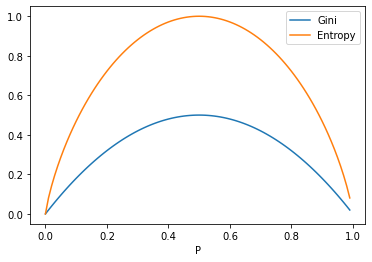

In [3]:
df.plot()

<AxesSubplot:xlabel='P'>

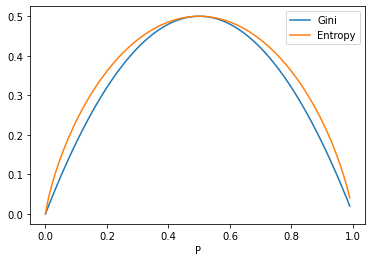

In [4]:
df_escalada = df.copy()
df_escalada['Entropy'] /= 2
df_escalada.plot()

## Sensibilidad, Derivamos

Text(0.5, 1.0, 'Zona mas definida')

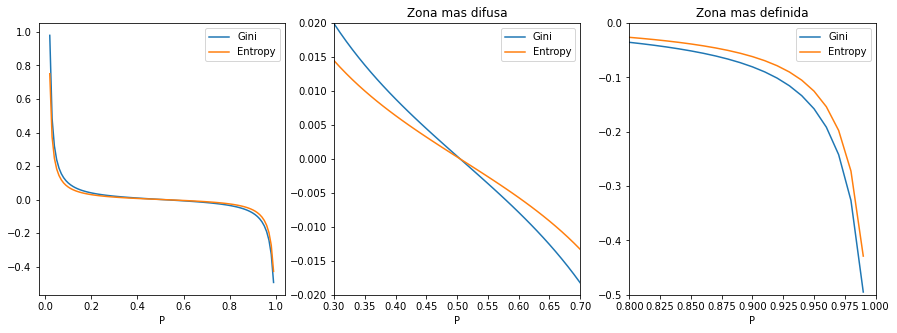

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5), ncols=3)

df.pct_change().plot(ax=ax[0])
df.pct_change().plot(xlim=(.3,.7), ylim=(-.02,.02), ax=ax[1])
df.pct_change().plot(xlim=(.8,1), ylim=(-.5,0), ax=ax[2])
ax[1].set_title('Zona mas difusa')
ax[2].set_title('Zona mas definida')

In [6]:
tasas = df.pct_change().abs().iloc[2:]
tasas.mean()

Gini       0.067372
Entropy    0.052136
dtype: float64

In [ ]:
# Aprendizaje Supervisado: Algoritmos de Clasificación

<img src="imagenes/ia_clas0.png" width=750>

<img src="imagenes/ia.jfif" width=600>

Tipos de algoritmos para resolver una clasificación:
    
    * Arboles de decisión
    * Máquinas de vectores de soporte
    * Naive Bayes
    * Regresión Logística
    * Bosques Aleatorios

# Arboles de decisión

<img src='imagenes/gashe.png'>

## Preparamos los datos

import yfinance as yf, numpy as np, pandas as pd

medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]

X

sum(y), len(y)   # fw positivo, totales

## Separamos los datos de entrenamiento de los de validación

len(X), len(y)

from sklearn.model_selection import train_test_split

# Entrenamos con el 60% de los datos al modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

len(X_train)

len(X_test)

X_train[:10]

## Importamos el modelo

from sklearn.tree import DecisionTreeClassifier
modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=6) # por default es gini, otros entropy

Parámetros importantes:
    
* criterion: entropy/gini
* <b>max_depth</b>: Cantidad de subnodos desde cada hilo ppal (profundidad)
* random_state

$$ {\text{Ganancia de información, Entropia}}(S)= \large - \sum _{i=1}^{n}p_{i}\log _{2}p_{i} $$

$$ {\text{Impureza de Gini} \hspace{0.5cm}  \large I_{G}(p)=\sum _{i=1}^{m}p_{i}(1-p_{i})=\sum _{i=1}^{m}(p_{i}-{p_{i}}^{2})=1-\sum _{i=1}^{m}{p_{i}}^{2}} $$

Ver Shannon y Weaber formulacion matematica de la teoría de la información

## Entrenamiento

modelo.fit(X_train, y_train)

## Corremos el modelo

y_pred = modelo.predict(X_test)
y_pred

pd.DataFrame(y_pred).groupby(0).size()

modelo.predict(X_test)

## Obtenemos las predicciones de probabilidad 

modelo.predict_proba(X_test)

## Matriz de Confusión

<img src='imagenes/machine_learning_mc_sklearn.png' width='600'>

### Matriz de confusión "a mano"

resultados = list(zip(y_test, y_pred))

manteca = 0
mike = 0
yoteavise = 0
allin = 0

for real, prediccion in resultados:
    
    if (real==0) & (prediccion==0):
        # Verdaderos negativos
        yoteavise +=1
    if (real==0) & (prediccion==1):
        # Falsos positivos
        allin +=1
    if (real==1) & (prediccion==0):
        # Falsos negativos
        mike +=1
    if (real==1) & (prediccion==1):
        # Verdaderos positivos
        manteca +=1


yoteavise, allin, mike, manteca

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
m = np.array(confusion_matrix(y_test, y_pred, normalize=None))
m

## Normalizado de matriz de confusión

m = np.array(confusion_matrix(y_test, y_pred, normalize='all'))
m

plot_confusion_matrix(modelo, X_test, y_test, values_format='.1%', normalize='all', cmap='Blues')

m = np.array(confusion_matrix(y_test, y_pred, normalize='pred'))
m

m = np.array(confusion_matrix(y_test, y_pred, normalize='true'))
m

from sklearn.metrics import confusion_matrix

m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

matriz = {'manteca':m[1][1], 'mike oscilator':m[1][0],'all in':m[0][1], 'yo te avise':m[0][0]}

resumen = {'aciertos' : f"{matriz['manteca']+matriz['yo te avise']:.1%}", 
           'sesgo +': f"{matriz['manteca']+matriz['all in']:.1%}"}

print('Arboles de decisión: \n',m,'\nPorcentajes:\n',matriz,'\n',resumen)



















### Ojo con la definición de tuplas

Si definimos una tupla como x=(1), me va a asignar el entero 1 a la variable "x"

Si quisiera que me asigne la tupla con el valor 1 como único valor debo poner x=(1,)

a = 5
b = (5)
c = (5,)

type(a), type(b), type(c)



## Vemos predicción de algún valor

X

X_full = data_full.iloc[:,-7:-1]
X_full

datosHoy = X_full.iloc[-1]
datosHoy

datosHoy.values

modelo.predict((datosHoy,))

modelo.predict_proba((datosHoy,))

ultimos = X_full[-5:]
prediccion_ultimos = modelo.predict(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)

ultimos = X_full[-5:]
prediccion_ultimos = modelo.predict_proba(ultimos)
print('\nPrediccion Ultimos 5 valores actuales\n',prediccion_ultimos)

## Graficamos el modelo

# pip install pydotplus

from IPython.display import Image  
from sklearn import tree
import pydotplus
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

cols = ['roll_vol','cr1','cr2','cr3']
targets = ['Sube','Baja']

dot_data = tree.export_graphviz(modelo, out_file=None, feature_names=X.columns, 
                                class_names=targets, rounded = True, filled= True)

graph = pydotplus.graph_from_dot_data(dot_data)  

# guardo la imagen en disco
graph.write_png("imagenes/gashe.png")

# imprimo en pantalla
Image(graph.create_png())

dot_data

## Overfiteamos

aciertos = []
for i in range(1,50):
    modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=i) #Definimos modelo
    modelo.fit(X_train, y_train) # Entrenamos
    y_pred = modelo.predict(X_test) # Corremos
    m = np.array(confusion_matrix(y_test, y_pred)) # medimos
    mp = (m/m.sum().sum() *100).round(2)
    aciertos.append( round(mp[0][0]+mp[1][1],2) )

aciertosTot = pd.DataFrame(aciertos)
aciertosTot.plot()

# Repaso en limpio

import yfinance as yf, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix


medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

data['target'] = 0
data.loc[data.fw >= 0 , 'target'] = 1

data_full = data.copy() # Esto nos va a servir despues cuando necesitemos los de hoy (sin etiquetas aun)
data = data.round(4).dropna()

y = list(data['target'])
X = data.iloc[:,-7:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

modelo = DecisionTreeClassifier(criterion = 'entropy', max_depth=7) 
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

m = np.array(confusion_matrix(y_test, y_pred, normalize='all')).round(2)

ultimos = data_full.iloc[-5:,-7:-1]
prediccion_ultimos = modelo.predict_proba(ultimos)

m, prediccion_ultimos

# Se acuerdan de la serializacion?

import pickle

with open('modelo_arboles.dat' , 'wb') as file:
    pickle.dump(modelo, file)

# Reiniciamos kernel y probamos modelo pre-fiteado

import pickle
with open('modelo_arboles.dat' , 'rb') as file:
    m_loaded = pickle.load(file)

import yfinance as yf, numpy as np, pandas as pd

medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')

dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = data['Adj Close'].shift(-ventana)/data['Adj Close']-1
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1

ultimos = data.iloc[-5:,-6:]
prediccion_ultimos = m_loaded.predict_proba(ultimos)
prediccion_ultimos





# OverSampling y UnderSampling

<img src="imagenes/os_us.png" width=800>





## Over Sampling:

Simplemente repitiendo al azar

* <b>RandomOverSampler</b>

Sintéticos

    * SMOTE 
    * BorderlineSMOTE (Líneas de separación jerarárquicas)
    * KMeansSMOTE (c/modelo de agrupamiento KMeans)
    * SVMSMOTE (c/modelo de agrupamiento SVM)
    * SMOTEN (para predictores discretos)
    * SMOTENC (mezcla de predictores continuos y discretos)
    * ADASYN (sinteticos adaptativos)

Paper original <b>SMOTE</b>, DOI: 10.1613/jair.301
<br>https://www.jair.org/index.php/jair/article/view/10302/24590

<b>BorderLine</b> DOI DOI:10.1007/11538059_91
<br>https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf

<b>ADASYN</b> DOI:10.1109/IJCNN.2008.4633969
<br>https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf





<br>
<img src="imagenes/os_1.png" width=500 style="float:left;margin-right:40px;margin-top:-20px;">
<img src="imagenes/os_2.png" width=400 style="float:left; margin-bottom:50px;">

## Under Sampling

* <b>RandomUnderSampler</b>

* <b>NearMiss</b> (usa KNN, busca mas separacion de grupos) 
* <b>ClusterCentroids</b> (Usa KMeans, remueve primero los mas parecidos, busca mas variabilidad, me gusta mas en la bolsa)
* CondensedNearestNeighbour (Busca la zona mas densa posible)
* EditedNearestNeighbours ENN (remueve primeros los korea del centro)
* RepeatedEditedNearestNeighbours (ENN recursivo)
* AllKNN (ENN adaptativo)
* InstanceHardnessThreshold (Usa cortes de clustering jerárquico y dendrogramas)
* NeighbourhoodCleaningRule (remueve primero los mas discordantes, saca ruido)
* OneSidedSelection 
* TomekLinks

<img src="imagenes/os_3.png" width=300>

<b>NearMiss</b>
<br>https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf

<b>CondensedNearestNeighbour</b> DOI 10.1109/TIT.1968.1054155
<br>https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1979-IEEE_TIT-Chidananda-IS-MNV.pdf

OneSideSelect
<br>https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf

Neighboorhood Cleaning Rule
<br>https://www.scirp.org/pdf/JBiSE20101000009_16323745.pdf

InstanceHardnessThreshold 
<br>https://link.springer.com/content/pdf/10.1007/s10994-013-5422-z.pdf

<b>Tomek</b> DOI 10.4236/jilsa.2015.74010
<br>https://www.scirp.org/(S(i43dyn45teexjx455qlt3d2q))/journal/paperinformation.aspx?paperid=60996

## Instalación e importación

# conda install -c conda-forge imbalanced-learn

from imblearn import over_sampling as os 
from imblearn import under_sampling as us

## Ejemplos

import pandas as pd
import numpy as np
import yfinance as yf


medias = ((63, 422), (38, 350), (72, 506))
ventana = 100

data = yf.download('GGAL', start='2000-01-01')


dif = data['Adj Close'].diff()
win = pd.DataFrame(np.where(dif > 0, dif, 0))
loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
ema_win = win.ewm(alpha=1/14).mean()
ema_loss = loss.ewm(alpha=1/14).mean()
rs = ema_win / ema_loss
rsi = 100 - (100 / (1 + rs))
rsi.index = data.index

data['pctChange'] = data['Adj Close'].pct_change()
data['fw'] = np.log(data['Adj Close'].shift(-ventana)/data['Adj Close'])
data['rsi'] = rsi/100
data['roll_vol'] = data['pctChange'].rolling(60).std() * 60**0.5
data['ema_vol'] = data['pctChange'].ewm(span=300).std() * 300**0.5
data['cruce_1'] = data['Adj Close'].rolling(medias[0][0]).mean()/data['Adj Close'].rolling(medias[0][1]).mean()-1
data['cruce_2'] = data['Adj Close'].rolling(medias[1][0]).mean()/data['Adj Close'].rolling(medias[1][1]).mean()-1
data['cruce_3'] = data['Adj Close'].rolling(medias[2][0]).mean()/data['Adj Close'].rolling(medias[2][1]).mean()-1
data.dropna(inplace=True)

data['se_vuela'] = np.where(data.fw > 0.5, 1, 0)

df = data.iloc[:, 8:]
df

df.groupby('se_vuela').size()

X, Y = df.iloc[:,:-1], df.iloc[:,-1]

### OS, Random, SMOTE

# Uso oversampling al azar
# Repite muestras del df original aleatoriamente

X_os, Y_os = os.RandomOverSampler().fit_resample(X,Y)

df_os = pd.concat([X_os,Y_os], axis=1)
df_os

df_os.groupby('se_vuela').size()

df.groupby('se_vuela').mean()

X_os, Y_os = os.RandomOverSampler(random_state=0).fit_resample(X,Y)
df_os = pd.concat([X_os,Y_os], axis=1)
df_os.groupby('se_vuela').mean()

X_os, Y_os = os.SMOTE(random_state=0).fit_resample(X,Y)
df_os = pd.concat([X_os,Y_os], axis=1)
df_os.groupby('se_vuela').mean()

### US, Random, NearMiss, 

df.groupby('se_vuela').size()

X_us, Y_us = us.RandomUnderSampler(random_state=0).fit_resample(X,Y)
df_us = pd.concat([X_us,Y_us], axis=1)
df_us.groupby('se_vuela').size(),    df_us.groupby('se_vuela').mean()

X_us, Y_us = us.NearMiss().fit_resample(X,Y)
df_us = pd.concat([X_us,Y_us], axis=1)
df_us.groupby('se_vuela').size(),    df_us.groupby('se_vuela').mean()



# Criterio de Entropía e impureza de gini

## Fórmulas

$$ {\text{Ganancia de información, Entropia}}(S)= \large - \sum _{i=1}^{n}p_{i}\log _{2}p_{i} $$

$$ {\text{Impureza de Gini} \hspace{0.5cm}  \large I_{G}(p)=\sum _{i=1}^{m}p_{i}(1-p_{i})=\sum _{i=1}^{m}(p_{i}-{p_{i}}^{2})=1-\sum _{i=1}^{m}{p_{i}}^{2}} $$

## Implementamos las funciones

from math import log
import numpy as np
import pandas as pd

def gini(p):
    return 1 - (p**2 + (1-p)**2)

def entropy(p, base=2):
    try:
        var =  abs(p*log(p, base)+(1-p)*log(1-p, base))
        return var
    except (ValueError):
        return 0

p_subas = np.linspace(0,1,100, endpoint=False)
data_gini = [gini(x) for x in p_subas]
data_entropy = [entropy(x) for x in p_subas]
df = pd.DataFrame(zip(p_subas, data_gini, data_entropy), columns=['P','Gini','Entropy']).set_index('P')
df

df.plot()

df_escalada = df.copy()
df_escalada['Entropy'] /= 2
df_escalada.plot()

## Sensibilidad, Derivamos

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5), ncols=3)

df.pct_change().plot(ax=ax[0])
df.pct_change().plot(xlim=(.3,.7), ylim=(-.02,.02), ax=ax[1])
df.pct_change().plot(xlim=(.8,1), ylim=(-.5,0), ax=ax[2])
ax[1].set_title('Zona mas difusa')
ax[2].set_title('Zona mas definida')

tasas = df.pct_change().abs().iloc[2:]
tasas.mean()





